# DQN Architecture Comparison: Basic, Double and Dueling DQNs

## Prompt
Implement and compare the Double DQN and Dueling DQN based on this notebook (`hw4-1.ipynb`). Focus on how they improve upon the basic DQN approach.

## Reply
This notebook implements and compares three variants of Deep Q-Networks (DQNs):
1. Basic DQN with Experience Replay
2. Double DQN (DDQN) 
3. Dueling DQN

We'll evaluate their performance in the Gridworld environment and analyze their differences in terms of:
- Win rate
- Convergence speed
- Learning stability
- Overestimation bias

## 1. Import Required Libraries and Setup Environment

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from IPython.display import clear_output

# Download Gridworld environment files
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

from Gridworld import Gridworld

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Action mapping
action_set = {
    0: 'u',  # up
    1: 'd',  # down
    2: 'l',  # left
    3: 'r'   # right
}

# Common parameters
input_size = 64  # 4x4x4 flattened
gamma = 0.9      # discount factor
epsilon_start = 1.0
epsilon_end = 0.1
learning_rate = 1e-3

# Training parameters
mem_size = 10000
batch_size = 128
max_moves = 50
sync_freq = 500  # Target network update frequency

Using device: cuda


## 2. Define Network Architectures

We'll define three different network architectures:
1. Basic DQN: Standard fully connected network with 2 hidden layers
2. Double DQN: Same architecture as Basic DQN, but uses two networks
3. Dueling DQN: Network architecture that separates value and advantage streams

In [14]:
# Basic DQN Network
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Dueling DQN Network
class DuelingDQN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(DuelingDQN, self).__init__()
        # Shared feature extraction layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        
        # Value stream
        self.value_stream = nn.Linear(hidden_size2, 1)
        
        # Advantage stream
        self.advantage_stream = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        features = F.relu(self.fc2(x))
        
        # Value function - estimates V(s)
        value = self.value_stream(features)
        
        # Advantage function - estimates A(s,a)
        advantage = self.advantage_stream(features)
        
        # Combine value and advantage to get Q-values
        # Using the formula: Q(s,a) = V(s) + (A(s,a) - mean(A(s,a')))
        # This helps with numerical stability and identifiability
        qvals = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return qvals

## 3. Helper Functions

Now we'll define helper functions for testing models and visualizing results.

In [15]:
# Function to test model performance
def test_model(model, num_episodes=100, mode='random', display=False):
    model.eval()  # Set the model to evaluation mode
    wins = 0
    steps_list = []
    
    for i in range(num_episodes):
        test_game = Gridworld(size=4, mode=mode)
        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
        state = torch.from_numpy(state_).float().to(device)
        
        if display and i == 0:
            print("Initial State:")
            print(test_game.display())
        
        status = 1
        steps = 0
        
        while status == 1:  # Game is ongoing
            qval = model(state)
            qval_ = qval.cpu().data.numpy()
            action_ = np.argmax(qval_)
            action = action_set[action_]
            
            if display and i == 0:
                print(f'Move #: {steps}; Taking action: {action}')
            
            test_game.makeMove(action)
            steps += 1
            
            state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
            state = torch.from_numpy(state_).float().to(device)
            
            if display and i == 0:
                print(test_game.display())
            
            reward = test_game.reward()
            
            if reward != -1:  # Terminal state reached
                if reward > 0:  # Win
                    status = 2
                    wins += 1
                    if display and i == 0:
                        print(f"Game won! Reward: {reward}")
                else:  # Loss
                    status = 0
                    if display and i == 0:
                        print(f"Game LOST. Reward: {reward}")
                
                steps_list.append(steps)
            
            if steps > max_moves:  # Too many moves
                if display and i == 0:
                    print("Game lost; too many moves.")
                status = 0
                steps_list.append(steps)
                break
    
    win_rate = wins / num_episodes * 100
    avg_steps = sum(steps_list) / len(steps_list) if steps_list else 0
    
    model.train()  # Set the model back to training mode
    return win_rate, avg_steps

# Function to plot training metrics
def plot_training_metrics(losses_list, rewards_list, steps_list, titles, figsize=(18, 6)):
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot losses
    for i, losses in enumerate(losses_list):
        axes[0].plot(losses, label=titles[i])
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Training Steps')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot rewards
    for i, rewards in enumerate(rewards_list):
        axes[1].plot(rewards, label=titles[i])
    axes[1].set_title('Episode Rewards')
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Reward')
    axes[1].legend()
    axes[1].grid(True)
    
    # Plot steps
    for i, steps in enumerate(steps_list):
        axes[2].plot(steps, label=titles[i])
    axes[2].set_title('Steps per Episode')
    axes[2].set_xlabel('Episodes')
    axes[2].set_ylabel('Steps')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Function to plot win rates
def plot_win_rates(win_rates, model_names, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    bars = plt.bar(model_names, win_rates)
    
    # Set different colors for each bar
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    for i, bar in enumerate(bars):
        bar.set_color(colors[i % len(colors)])
    
    plt.title('Win Rates Comparison')
    plt.xlabel('Model Type')
    plt.ylabel('Win Rate (%)')
    plt.ylim(0, 100)
    
    # Add value labels on top of bars
    for i, v in enumerate(win_rates):
        plt.text(i, v + 2, f"{v:.1f}%", ha='center')
    
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

## 4. Basic DQN Implementation

First, we'll implement the baseline DQN with experience replay from Program 3.5.

In [16]:
def train_basic_dqn(episodes=1000, hidden_size1=150, hidden_size2=100):
    # Create the DQN model
    model = DQN(input_size, hidden_size1, hidden_size2, 4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    
    # Initialize training metrics
    losses = []
    episode_rewards = []
    episode_steps = []
    replay = deque(maxlen=mem_size)
    epsilon = epsilon_start
    
    # Training loop
    step = 0
    
    for episode in range(episodes):
        game = Gridworld(size=4, mode='random')
        state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
        state = torch.from_numpy(state_).float().to(device)
        
        status = 1
        moves = 0
        episode_reward = 0
        
        while status == 1:
            step += 1
            moves += 1
            
            # Epsilon-greedy action selection
            qval = model(state)
            if random.random() < epsilon:
                action_ = random.randint(0, 3)  # Explore
            else:
                qval_ = qval.cpu().data.numpy()
                action_ = np.argmax(qval_)  # Exploit
            
            action = action_set[action_]
            
            # Execute action
            game.makeMove(action)
            
            # Get next state and reward
            next_state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
            next_state = torch.from_numpy(next_state_).float().to(device)
            reward = game.reward()
            episode_reward += reward
            
            # Check if game is done
            done = reward != -1
            
            # Store experience
            replay.append((state, action_, reward, next_state, done))
            
            # Update state
            state = next_state
            
            # Sample from experience replay and perform learning update
            if len(replay) > batch_size:
                minibatch = random.sample(replay, batch_size)
                
                # Extract batch data
                state_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
                action_batch = torch.tensor([a for (s1, a, r, s2, d) in minibatch]).long().to(device)
                reward_batch = torch.tensor([r for (s1, a, r, s2, d) in minibatch]).float().to(device)
                next_state_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
                done_batch = torch.tensor([d for (s1, a, r, s2, d) in minibatch]).float().to(device)
                
                # Compute current Q values
                Q_current = model(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
                
                # Compute target Q values
                with torch.no_grad():
                    Q_next = model(next_state_batch)
                    max_Q_next = torch.max(Q_next, dim=1)[0]
                    Q_target = reward_batch + gamma * max_Q_next * (1 - done_batch)
                
                # Update model
                loss = loss_fn(Q_current, Q_target)
                losses.append(loss.item())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Check if game is finished
            if done or moves >= max_moves:
                status = 0
            
        # Decay epsilon
        epsilon = max(epsilon_end, epsilon - (epsilon_start - epsilon_end) / episodes)
        
        # Record episode metrics
        episode_rewards.append(episode_reward)
        episode_steps.append(moves)
        
        # Print progress
        if episode % 100 == 0:
            print(f"Episode: {episode}, Loss: {np.mean(losses[-100:]):.4f}, "
                  f"Epsilon: {epsilon:.2f}, Reward: {episode_reward}")
            clear_output(wait=True)
    
    return model, losses, episode_rewards, episode_steps

## 5. Double DQN Implementation

Next, we'll implement the Double DQN architecture, which uses two networks to reduce overestimation bias:
1. Online network: Used for action selection
2. Target network: Used for value estimation

The target network is updated periodically with the weights of the online network.

In [17]:
def train_double_dqn(episodes=1000, hidden_size1=150, hidden_size2=100):
    # Create online and target networks
    online_model = DQN(input_size, hidden_size1, hidden_size2, 4).to(device)
    target_model = copy.deepcopy(online_model).to(device)
    
    # Freeze target network parameters
    for param in target_model.parameters():
        param.requires_grad = False
    
    optimizer = torch.optim.Adam(online_model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    
    # Initialize training metrics
    losses = []
    episode_rewards = []
    episode_steps = []
    replay = deque(maxlen=mem_size)
    epsilon = epsilon_start
    
    # Training loop
    step = 0
    
    for episode in range(episodes):
        game = Gridworld(size=4, mode='random')
        state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
        state = torch.from_numpy(state_).float().to(device)
        
        status = 1
        moves = 0
        episode_reward = 0
        
        while status == 1:
            step += 1
            moves += 1
            
            # Epsilon-greedy action selection with online network
            qval = online_model(state)
            if random.random() < epsilon:
                action_ = random.randint(0, 3)  # Explore
            else:
                qval_ = qval.cpu().data.numpy()
                action_ = np.argmax(qval_)  # Exploit
            
            action = action_set[action_]
            
            # Execute action
            game.makeMove(action)
            
            # Get next state and reward
            next_state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
            next_state = torch.from_numpy(next_state_).float().to(device)
            reward = game.reward()
            episode_reward += reward
            
            # Check if game is done
            done = reward != -1
            
            # Store experience
            replay.append((state, action_, reward, next_state, done))
            
            # Update state
            state = next_state
            
            # Sample from experience replay and perform learning update
            if len(replay) > batch_size:
                minibatch = random.sample(replay, batch_size)
                
                # Extract batch data
                state_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
                action_batch = torch.tensor([a for (s1, a, r, s2, d) in minibatch]).long().to(device)
                reward_batch = torch.tensor([r for (s1, a, r, s2, d) in minibatch]).float().to(device)
                next_state_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
                done_batch = torch.tensor([d for (s1, a, r, s2, d) in minibatch]).float().to(device)
                
                # Compute current Q values
                Q_current = online_model(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
                
                # Double DQN: use online network for action selection and target network for value estimation
                with torch.no_grad():
                    # Select action with online network (argmax)
                    online_next_q_values = online_model(next_state_batch)
                    best_actions = torch.argmax(online_next_q_values, dim=1)
                    
                    # Evaluate action with target network
                    next_q_values = target_model(next_state_batch)
                    max_Q_next = next_q_values.gather(1, best_actions.unsqueeze(1)).squeeze(1)
                    
                    # Compute target Q value
                    Q_target = reward_batch + gamma * max_Q_next * (1 - done_batch)
                
                # Update model
                loss = loss_fn(Q_current, Q_target)
                losses.append(loss.item())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Periodically update target network
                if step % sync_freq == 0:
                    target_model.load_state_dict(online_model.state_dict())
            
            # Check if game is finished
            if done or moves >= max_moves:
                status = 0
            
        # Decay epsilon
        epsilon = max(epsilon_end, epsilon - (epsilon_start - epsilon_end) / episodes)
        
        # Record episode metrics
        episode_rewards.append(episode_reward)
        episode_steps.append(moves)
        
        # Print progress
        if episode % 100 == 0:
            print(f"Episode: {episode}, Loss: {np.mean(losses[-100:]):.4f}, "
                  f"Epsilon: {epsilon:.2f}, Reward: {episode_reward}")
            clear_output(wait=True)
    
    return online_model, losses, episode_rewards, episode_steps

## 6. Dueling DQN Implementation

Now we'll implement the Dueling DQN architecture, which separates the estimation of state values and action advantages.

The key advantage is that it can learn which states are valuable without having to learn the effect of each action in each state, leading to more efficient learning, especially in states where actions don't significantly affect the outcome.

In [18]:
def train_dueling_dqn(episodes=1000, hidden_size1=150, hidden_size2=100):
    # Create online and target networks (both dueling architecture)
    online_model = DuelingDQN(input_size, hidden_size1, hidden_size2, 4).to(device)
    target_model = copy.deepcopy(online_model).to(device)
    
    # Freeze target network parameters
    for param in target_model.parameters():
        param.requires_grad = False
    
    optimizer = torch.optim.Adam(online_model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    
    # Initialize training metrics
    losses = []
    episode_rewards = []
    episode_steps = []
    replay = deque(maxlen=mem_size)
    epsilon = epsilon_start
    
    # Training loop
    step = 0
    
    for episode in range(episodes):
        game = Gridworld(size=4, mode='random')
        state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
        state = torch.from_numpy(state_).float().to(device)
        
        status = 1
        moves = 0
        episode_reward = 0
        
        while status == 1:
            step += 1
            moves += 1
            
            # Epsilon-greedy action selection with online network
            qval = online_model(state)
            if random.random() < epsilon:
                action_ = random.randint(0, 3)  # Explore
            else:
                qval_ = qval.cpu().data.numpy()
                action_ = np.argmax(qval_)  # Exploit
            
            action = action_set[action_]
            
            # Execute action
            game.makeMove(action)
            
            # Get next state and reward
            next_state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
            next_state = torch.from_numpy(next_state_).float().to(device)
            reward = game.reward()
            episode_reward += reward
            
            # Check if game is done
            done = reward != -1
            
            # Store experience
            replay.append((state, action_, reward, next_state, done))
            
            # Update state
            state = next_state
            
            # Sample from experience replay and perform learning update
            if len(replay) > batch_size:
                minibatch = random.sample(replay, batch_size)
                
                # Extract batch data
                state_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
                action_batch = torch.tensor([a for (s1, a, r, s2, d) in minibatch]).long().to(device)
                reward_batch = torch.tensor([r for (s1, a, r, s2, d) in minibatch]).float().to(device)
                next_state_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
                done_batch = torch.tensor([d for (s1, a, r, s2, d) in minibatch]).float().to(device)
                
                # Compute current Q values
                Q_current = online_model(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
                
                # Use Double DQN logic with dueling networks
                with torch.no_grad():
                    # Select action with online network (argmax)
                    online_next_q_values = online_model(next_state_batch)
                    best_actions = torch.argmax(online_next_q_values, dim=1)
                    
                    # Evaluate action with target network
                    next_q_values = target_model(next_state_batch)
                    max_Q_next = next_q_values.gather(1, best_actions.unsqueeze(1)).squeeze(1)
                    
                    # Compute target Q value
                    Q_target = reward_batch + gamma * max_Q_next * (1 - done_batch)
                
                # Update model
                loss = loss_fn(Q_current, Q_target)
                losses.append(loss.item())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Periodically update target network
                if step % sync_freq == 0:
                    target_model.load_state_dict(online_model.state_dict())
            
            # Check if game is finished
            if done or moves >= max_moves:
                status = 0
            
        # Decay epsilon
        epsilon = max(epsilon_end, epsilon - (epsilon_start - epsilon_end) / episodes)
        
        # Record episode metrics
        episode_rewards.append(episode_reward)
        episode_steps.append(moves)
        
        # Print progress
        if episode % 100 == 0:
            print(f"Episode: {episode}, Loss: {np.mean(losses[-100:]):.4f}, "
                  f"Epsilon: {epsilon:.2f}, Reward: {episode_reward}")
            clear_output(wait=True)
    
    return online_model, losses, episode_rewards, episode_steps

## 7. Train and Compare Models

Now we'll train each model variant and compare their performance.

Dueling DQN training complete


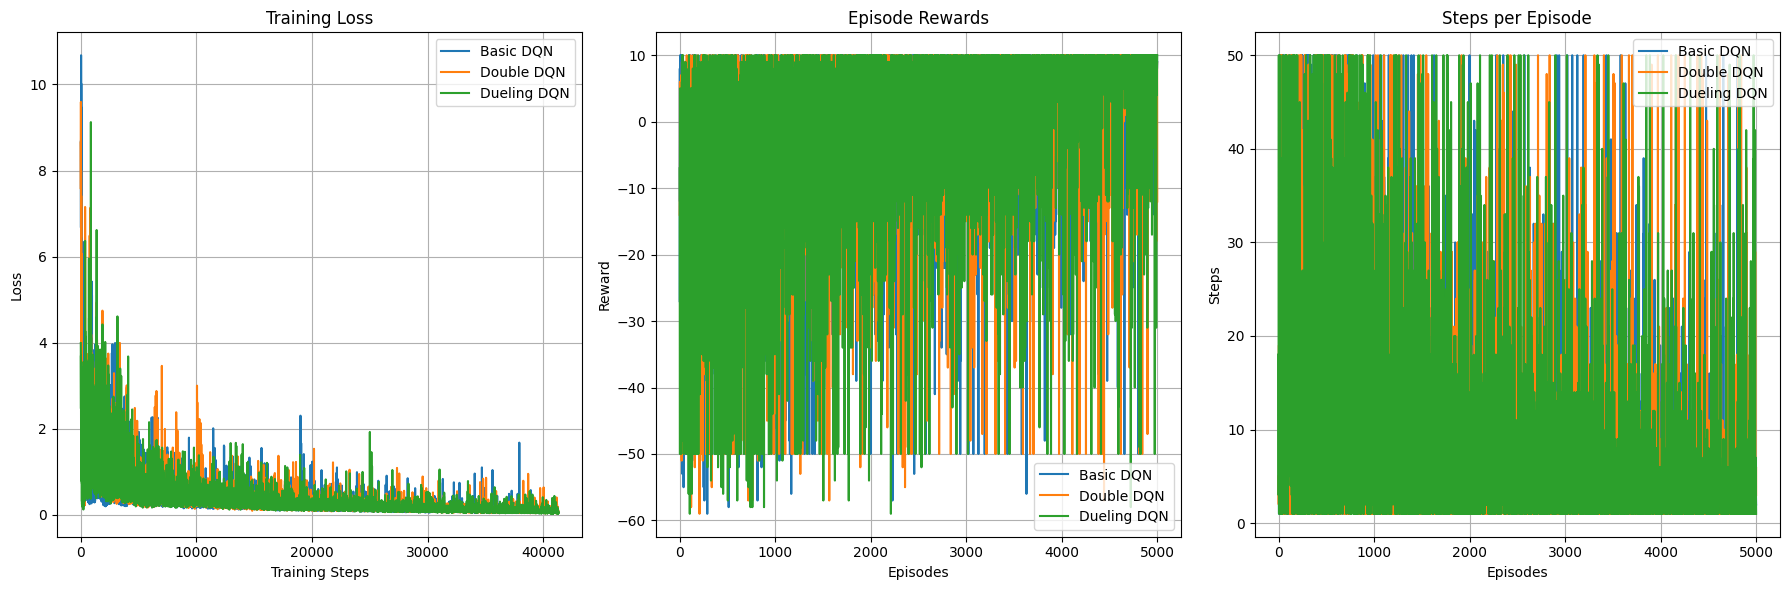

In [19]:
# Set a smaller number of episodes for quicker training
training_episodes = 5000

print("Training Basic DQN...")
basic_model, basic_losses, basic_rewards, basic_steps = train_basic_dqn(episodes=training_episodes)
print("Basic DQN training complete")

print("Training Double DQN...")
double_model, double_losses, double_rewards, double_steps = train_double_dqn(episodes=training_episodes)
print("Double DQN training complete")

print("Training Dueling DQN...")
dueling_model, dueling_losses, dueling_rewards, dueling_steps = train_dueling_dqn(episodes=training_episodes)
print("Dueling DQN training complete")

# Now that all models are trained, let's visualize the training process
plot_training_metrics(
    [basic_losses, double_losses, dueling_losses],
    [basic_rewards, double_rewards, dueling_rewards],
    [basic_steps, double_steps, dueling_steps],
    ['Basic DQN', 'Double DQN', 'Dueling DQN']
)

## 8. Evaluate Model Performance

Let's test each model on multiple episodes and compare their win rates.

Testing Basic DQN...
Initial State:
[[' ' ' ' 'P' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' 'P' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[[' ' ' ' ' ' ' ']
 ['P' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 3; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 ['P' ' ' 'W' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 4; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 ['+' ' ' ' ' ' ']]
Game won! Reward: 10
Basic DQN - Win Rate: 95.40%, Avg Steps: 5.45

Testing Double DQN...
Initial State:
[[' ' ' ' ' ' ' ']
 [' ' '-' 'P' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 ['W' ' ' 'P' ' ']
 [' ' ' ' '+' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 ['W' ' '

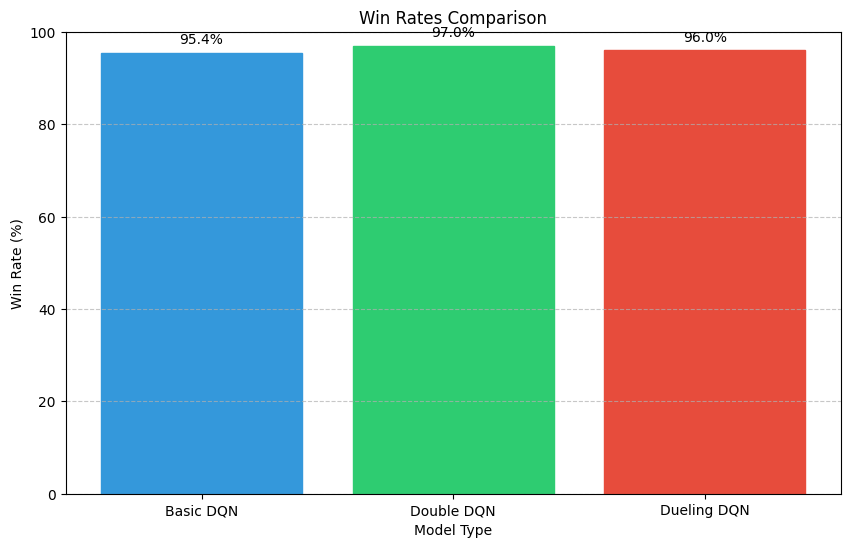

In [20]:
# Test each model
print("Testing Basic DQN...")
basic_win_rate, basic_avg_steps = test_model(basic_model, num_episodes=1000, display=True)
print(f"Basic DQN - Win Rate: {basic_win_rate:.2f}%, Avg Steps: {basic_avg_steps:.2f}")

print("\nTesting Double DQN...")
double_win_rate, double_avg_steps = test_model(double_model, num_episodes=1000, display=True)
print(f"Double DQN - Win Rate: {double_win_rate:.2f}%, Avg Steps: {double_avg_steps:.2f}")

print("\nTesting Dueling DQN...")
dueling_win_rate, dueling_avg_steps = test_model(dueling_model, num_episodes=1000, display=True)
print(f"Dueling DQN - Win Rate: {dueling_win_rate:.2f}%, Avg Steps: {dueling_avg_steps:.2f}")

# Plot win rates
plot_win_rates(
    [basic_win_rate, double_win_rate, dueling_win_rate],
    ['Basic DQN', 'Double DQN', 'Dueling DQN']
)

## 9. Additional Analysis: Overestimation Bias

One of the key issues that Double DQN addresses is the overestimation bias in Q-learning.
Let's examine this by comparing the Q-value distributions between our models.

/tmp/ipykernel_1024451/1151930225.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(q_values, labels=['Basic DQN', 'Double DQN', 'Dueling DQN'])


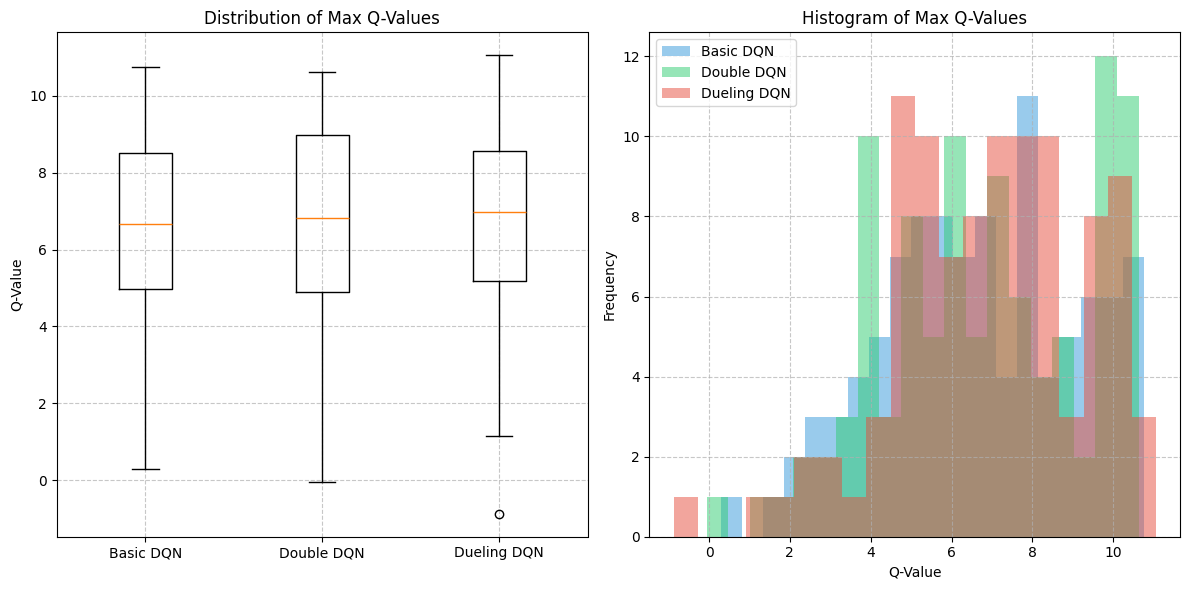

Basic DQN - Mean Q-value: 6.67, Median: 6.66, Max: 10.76, Min: 0.29
Double DQN - Mean Q-value: 6.77, Median: 6.83, Max: 10.63, Min: -0.06
Dueling DQN - Mean Q-value: 6.90, Median: 6.97, Max: 11.06, Min: -0.88


In [21]:
def compare_q_value_estimations(models, num_states=100):
    """Compare the Q-value estimations across different models"""
    # Generate random states
    states = []
    for _ in range(num_states):
        game = Gridworld(size=4, mode='random')
        state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
        state = torch.from_numpy(state_).float().to(device)
        states.append(state)
    
    # Get Q-value estimations for each model
    q_values = []
    for model in models:
        model.eval()
        model_q_values = []
        with torch.no_grad():
            for state in states:
                q_vals = model(state).cpu().numpy().flatten()
                model_q_values.append(np.max(q_vals))  # Store the max Q-value
        q_values.append(model_q_values)
    
    # Plot the distribution of Q-values
    plt.figure(figsize=(12, 6))
    
    # Box plot
    plt.subplot(1, 2, 1)
    plt.boxplot(q_values, labels=['Basic DQN', 'Double DQN', 'Dueling DQN'])
    plt.title('Distribution of Max Q-Values')
    plt.ylabel('Q-Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Histogram
    plt.subplot(1, 2, 2)
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    for i, (q_vals, label) in enumerate(zip(q_values, ['Basic DQN', 'Double DQN', 'Dueling DQN'])):
        plt.hist(q_vals, bins=20, alpha=0.5, color=colors[i], label=label)
    plt.title('Histogram of Max Q-Values')
    plt.xlabel('Q-Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    for i, label in enumerate(['Basic DQN', 'Double DQN', 'Dueling DQN']):
        print(f"{label} - Mean Q-value: {np.mean(q_values[i]):.2f}, "
              f"Median: {np.median(q_values[i]):.2f}, "
              f"Max: {np.max(q_values[i]):.2f}, "
              f"Min: {np.min(q_values[i]):.2f}")

# Compare Q-value estimations
compare_q_value_estimations([basic_model, double_model, dueling_model])

## 10. Learning Stability Analysis

Let's analyze the stability of learning by looking at the variance in episode rewards and loss values.

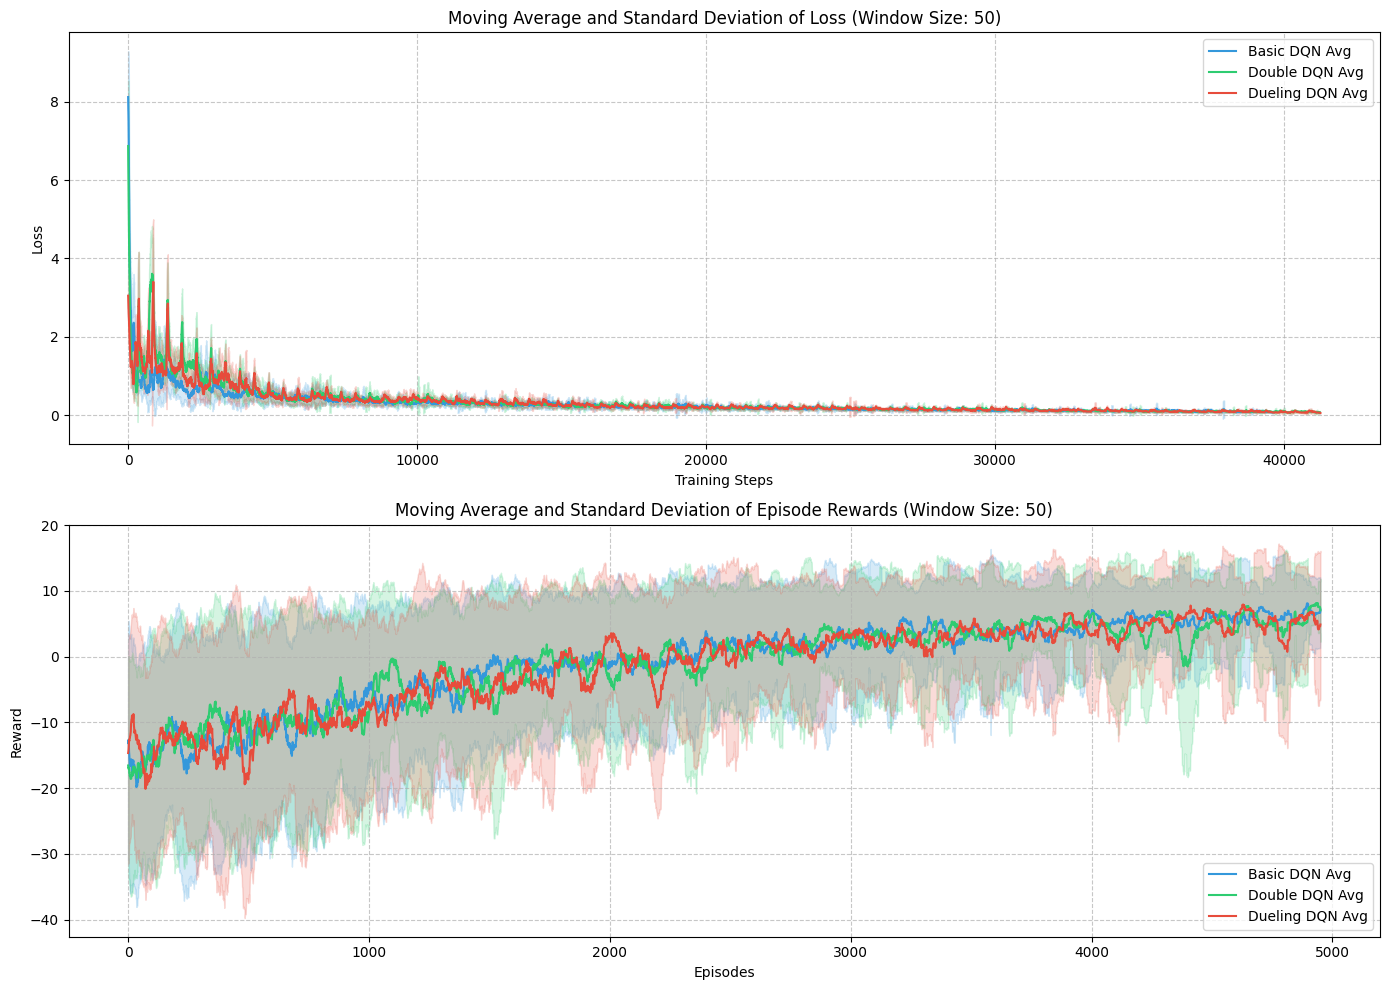

Learning Stability Metrics:

Basic DQN:
  Loss - Mean: 0.2933, Std Dev: 0.4340
  Rewards - Mean: -0.8960, Std Dev: 13.3201

Double DQN:
  Loss - Mean: 0.3372, Std Dev: 0.4985
  Rewards - Mean: -1.1650, Std Dev: 13.6201

Dueling DQN:
  Loss - Mean: 0.3195, Std Dev: 0.4003
  Rewards - Mean: -1.4340, Std Dev: 14.0137


In [22]:
def analyze_learning_stability(losses_list, rewards_list, window_size=50):
    """
    Analyze the stability of learning by computing moving averages and standard deviations
    """
    models = ['Basic DQN', 'Double DQN', 'Dueling DQN']
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    
    # Function to compute moving statistics
    def compute_moving_stats(data, window):
        data = np.array(data)
        avg = []
        std = []
        for i in range(len(data) - window + 1):
            window_data = data[i:i+window]
            avg.append(np.mean(window_data))
            std.append(np.std(window_data))
        return np.array(avg), np.array(std)
    
    # Plot moving average and standard deviation for losses
    plt.figure(figsize=(14, 10))
    
    # Loss stability
    plt.subplot(2, 1, 1)
    for i, losses in enumerate(losses_list):
        avg_loss, std_loss = compute_moving_stats(losses, window_size)
        x = np.arange(len(avg_loss))
        
        plt.plot(x, avg_loss, label=f"{models[i]} Avg", color=colors[i])
        plt.fill_between(x, avg_loss-std_loss, avg_loss+std_loss, alpha=0.2, color=colors[i])
    
    plt.title(f'Moving Average and Standard Deviation of Loss (Window Size: {window_size})')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Reward stability
    plt.subplot(2, 1, 2)
    for i, rewards in enumerate(rewards_list):
        avg_reward, std_reward = compute_moving_stats(rewards, min(window_size, len(rewards)//5))
        x = np.arange(len(avg_reward))
        
        plt.plot(x, avg_reward, label=f"{models[i]} Avg", color=colors[i])
        plt.fill_between(x, avg_reward-std_reward, avg_reward+std_reward, alpha=0.2, color=colors[i])
    
    plt.title(f'Moving Average and Standard Deviation of Episode Rewards (Window Size: {min(window_size, len(rewards_list[0])//5)})')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print stability metrics
    print("Learning Stability Metrics:")
    for i, model in enumerate(models):
        print(f"\n{model}:")
        print(f"  Loss - Mean: {np.mean(losses_list[i]):.4f}, Std Dev: {np.std(losses_list[i]):.4f}")
        print(f"  Rewards - Mean: {np.mean(rewards_list[i]):.4f}, Std Dev: {np.std(rewards_list[i]):.4f}")

# Analyze learning stability
analyze_learning_stability(
    [basic_losses, double_losses, dueling_losses],
    [basic_rewards, double_rewards, dueling_rewards]
)